#Yeast Dosage-Response Curve

This is data from a real experiment, measuring the dose response of an engineered yeast line to isopentyladenine, or IP.  The yeast is engineered with a basic GFP reporter, and GFP fluorescence is measured after 12 hours, at which time we expect the cells to be at steady-state.

(Reference: [Chen et al, Nature Biotech 2005](http://www.nature.com/nbt/journal/v23/n12/abs/nbt1162.html))

---

Set up the Jupyter `matplotlib` integration, and import the `cytoflow` module.

In [1]:
%matplotlib inline

import cytoflow as flow

First we set up the `Experiment`.  This is primarily the mapping between the flow data (wells on a microtitre plate, here) and the metadata (experimental conditions, in this case the IP concentration.)

For this experiment, I did a serial dilution with three dilutions per log.  Note that I specify that this metadata is of type `log`, which is represented internally as a `numpy` type `float`, but is plotted on a log scale when we go to visualize it.

Also note that, in order to keep the size of the source distribution manageable, I've only included 1000 events from each tube in the example files.  The actual data set has 30,000 events from each, which gives a much prettier dose-response curve!

In [2]:
inputs = {
    "Yeast_B1_B01.fcs" : 5.0,
    "Yeast_B2_B02.fcs" : 3.75,
    "Yeast_B3_B03.fcs" : 2.8125,
    "Yeast_B4_B04.fcs" : 2.109,
    "Yeast_B5_B05.fcs" : 1.5820,
    "Yeast_B6_B06.fcs" : 1.1865,
    "Yeast_B7_B07.fcs" : 0.8899,
    "Yeast_B8_B08.fcs" : 0.6674,
    "Yeast_B9_B09.fcs" : 0.5,
    "Yeast_B10_B10.fcs" : 0.3754,
    "Yeast_B11_B11.fcs" : 0.2816,
    "Yeast_B12_B12.fcs" : 0.2112,
    "Yeast_C1_C01.fcs" : 0.1584,
    "Yeast_C2_C02.fcs" : 0.1188,
    "Yeast_C3_C03.fcs" : 0.0892,
    "Yeast_C4_C04.fcs" : 0.0668,
    "Yeast_C5_C05.fcs" : 0.05,
    "Yeast_C6_C06.fcs" : 0.0376,
    "Yeast_C7_C07.fcs" : 0.0282,
    "Yeast_C8_C08.fcs" : 0.0211,
    "Yeast_C9_C09.fcs" : 0.0159
}

tubes = []
for filename, ip in inputs.iteritems():
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip}))
    
ex = flow.ImportOp(conditions = {'IP' : "log"},
                   tubes = tubes).apply()

Set `logicle` as the default plot scale:

In [3]:
flow.set_default_scale("logicle")

In [4]:
ex["SSC-A"].min()

-752.0

The first step in most cytometry workflows is to filter out debris and aggregates based on morphological parameters (the forward- and side-scatter measurements.)  So let's have a look at the FSC-A and SSC-A channels.

Remember, because we're not specifying otherwise, this is a plot of *all of the data* in the experiment, not a single tube!

/home/brian/src/cytoflow/cytoflow/utility/logicle_scale.py:152: CytoflowWarning: Channel FSC-A doesn't have any negative data. Try a log transform instead.
  CytoflowWarning)
/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


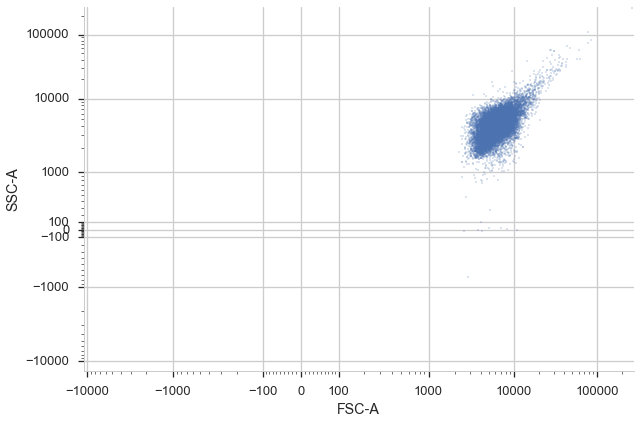

In [5]:
flow.ScatterplotView(xchannel = "FSC-A",
                     ychannel = "SSC-A").plot(ex)

Oops!  The biexponential scale is really intended for channels that have events around 0, with some negative events; let's use a log scale on both FSC-A and SSC-A in the future.

Because this is yeast growing in log phase on a drum roller, the distributions in FSC-A and SSC-A are pretty tight.  Let's fit a 2D gaussian to it, and gate out any data that is more than three standard deviations from the mean.

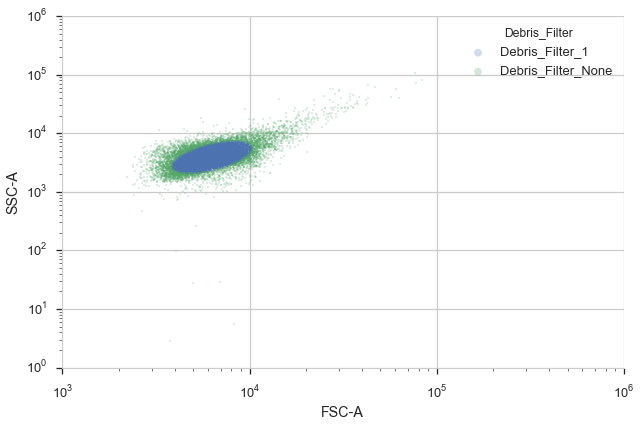

In [6]:
g = flow.GaussianMixture2DOp(name = "Debris_Filter",
                             xchannel = "FSC-A",
                             xscale = "log",
                             ychannel = "SSC-A",
                             yscale = "log",
                             num_components = 1,
                             sigma = 3)
g.estimate(ex)
g.default_view().plot(ex)

ex2 = g.apply(ex)

Alright, a quick aesthetic aside.  In order to select events that are inside the 2D gaussian gate, we're going to have to use an ugly subset string like `"Debris_Filter == 'Debris_Filter_1'"`.  Yuck.  Let's add another piece of metadata, called `Debris`, which is `True` if .... the event is debris, and `False` if it's actually a cell.  It's purely aesthetic, here, but if we had multiple morphology gates this might actually save us a ton of typing and make our analysis less error-prone.

In [7]:
ex2.add_condition("Debris", "bool", ex2["Debris_Filter"] == "Debris_Filter_None")

Now, let's look at the FITC-A channel, which is the one we're interested in.  First of all, just check histograms of the FITC-A distribution in each tube.  Make sure to set the `subset` trait to only include the events that aren't debris!

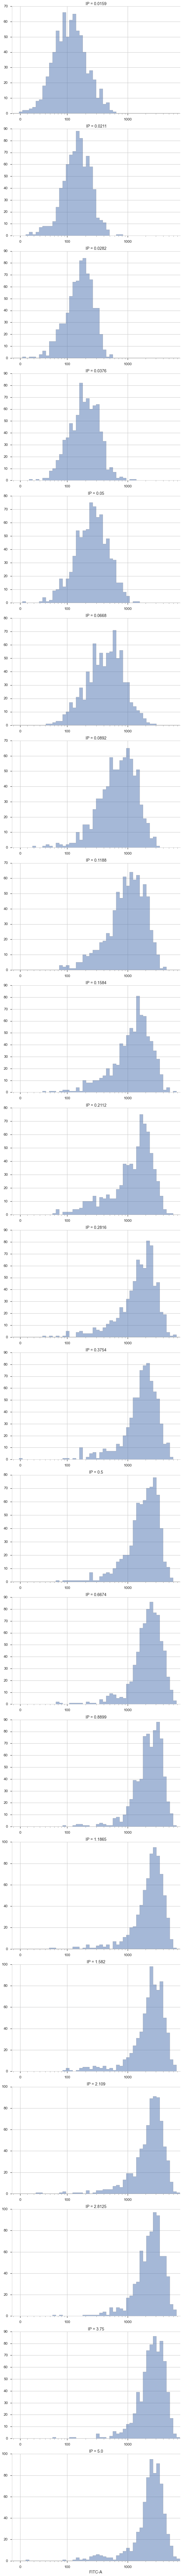

In [8]:
flow.HistogramView(channel = "FITC-A",
                   yfacet = "IP",
                   subset = "Debris == False").plot(ex2)

Sure enough, looking at the plots, it's clear that the histogram peak moves to the right as the IP concentration increases.

Now, let's get what we came for: a dose-response curve.  The `Stats1DView` view subsets the experiment by the metadata field specified in `variable` (in this case the "IP" variable) and then applies `yfunction` to each subset.  `yfunction` must be a function that takes a single list-like argument and returns a single float; it is applied to the `ychannel` channel of each subset.  In this case, the distributions are log-normally distributed, so let's use a geometric mean as a measure of center.

Again, remember to specify the subset we're interested in.

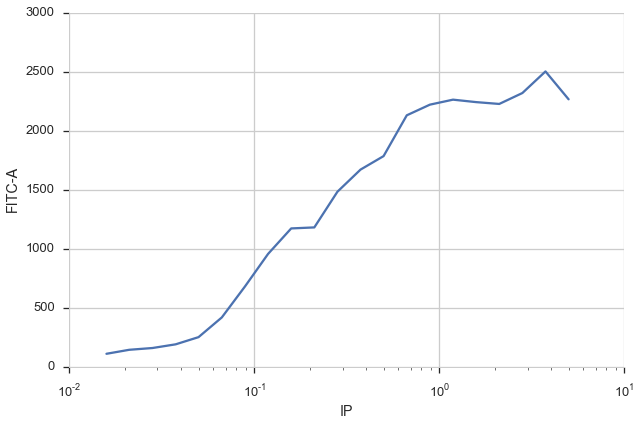

In [9]:
flow.Stats1DView(by = "IP",
                 ychannel = "FITC-A",
                 yfunction = flow.geom_mean,
                 subset = "Debris == False").plot(ex2)

And of course, because the underlying data is just a `pandas.DataFrame`, we can manipulate it with the rest of the Scientific Python ecosystem.  Here, we get the actual geometric means in a table that we can manipulate further, using `pandas.DataFrame.groupby`.

In [10]:
(ex2.data.query("Debris == False")[['IP', 'FITC-A']]
         .groupby('IP')
         .agg(flow.geom_mean))

,FITC-A
IP,
0.0159,108.111191
0.0211,141.999116
0.0282,157.140483
0.0376,188.344775
0.0500,249.401844
0.0668,416.628259
0.0892,680.410392
0.1188,955.793469
0.1584,1172.023941
